In [270]:
import pandas as pd

_stations = pd.DataFrame([
  {"id":1,"name":"Fairland Station 621","lat":39.584494256624545,"lon":-85.8656116467432},
  {"id":2,"name":"Moral Township Station 681","lat":39.6387254,"lon":-85.9070139},
  {"id":3,"name":"Needham Station 81","lat":39.529953,"lon":-85.9709754},
  {"id":4,"name":"Marietta Station 671","lat":39.4406702,"lon":-85.8810707},
  {"id":5,"name":"Shelbyville Station 691","lat":39.5227097,"lon":-85.7786288},
  {"id":6,"name":"IFD Station 16","lat":39.6691316,"lon":-86.0065276},
  {"id":7,"name":"Needham Station 82","lat":39.6040567,"lon":-85.9990409},
  {"id":8,"name":"Fountaintown Station 612","lat":39.6937218,"lon":-85.779439},
  {"id":9,"name":"IFD Station 55","lat":39.6962247,"lon":-85.9795233},
  {"id":10,"name":"Morristown Station 651","lat":39.6760901,"lon":-85.7045637},
  {"id":11,"name":"Waldron Station 641","lat":39.4537326,"lon":-85.6662435},
  {"id":12,"name":"Flat Rock Station 631","lat":39.3641328,"lon":-85.8309059},
  {"id":13,"name":"Sugar Creek Township Station 45","lat":39.7338448,"lon":-85.9131422},
  {"id":14,"name":"Manilla Station 61","lat":39.5710743,"lon":-85.617652},
  {"id":15,"name":"Whiteland Station 71","lat":39.5484272,"lon":-86.0747433},
  {"id":16,"name":"Shelbyville Station 692","lat":39.51627,"lon":-85.7434899},
  {"id":17,"name":"Shelbyville Station 693","lat":39.5055857,"lon":-85.7945173},
  {"id":18,"name":"Franklin Station 23","lat":39.523629,"lon":-86.0737878},
  {"id":19,"name":"Greenwood Station 91","lat":39.6134433,"lon":-86.1040209},
  {"id":20,"name":"St Paul Station 41","lat":39.4282778,"lon":-85.6285885},
  {"id":21,"name":"Sugar Creek Township Station 42","lat":39.7762501,"lon":-85.896068},
  {"id":22,"name":"Greenwood Station 94","lat":39.625805791286666,"lon":-86.06305093068505},
  {"id":23,"name":"New Whiteland Station 11","lat":39.5577404582559,"lon":-86.09102800041359},
  {"id":24,"name":"Franklin Station 22","lat":39.482230271604614,"lon":-86.02353331575846},
])

_apparatus = pd.DataFrame([
  {"id":1,"name":"73-Fairland-E621","station_id":1,"types":"engine"},
  {"id":2,"name":"73-Fairland-R621","station_id":1,"types":"engine,rescue"},
  {"id":3,"name":"73-Moral-E681","station_id":2,"types":"engine"},
  {"id":4,"name":"73-Moral-E682","station_id":2,"types":"engine"},
  {"id":5,"name":"73-Shelbyville-E691","station_id":5,"types":"engine"},
  {"id":6,"name":"73-Morristown-E651","station_id":10,"types":"engine"},
  {"id":7,"name":"73-Morristown-E652","station_id":10,"types":"engine"},
  {"id":8,"name":"73-Waldron-E641","station_id":11,"types":"engine"},
  {"id":9,"name":"30-Sugar Creek-E445","station_id":13,"types":"engine"},
  {"id":10,"name":"73-Shelbyville-E693","station_id":17,"types":"engine"},
  {"id":11,"name":"41-Franklin-E23","station_id":18,"types":"engine"},
  {"id":12,"name":"16-St. Paul-E841","station_id":20,"types":"engine"},
  {"id":13,"name":"30-Sugar Creek-E442","station_id":21,"types":"engine"},
  {"id":14,"name":"41-Needham-PT81","station_id":3,"types":"engine,tanker"},
  {"id":15,"name":"41-Needham-E82","station_id":7,"types":"engine"},
  {"id":16,"name":"73-Marietta-E671","station_id":4,"types":"engine"},
  {"id":17,"name":"49-IFD-E16","station_id":6,"types":"engine"},
  {"id":18,"name":"41-Whiteland-E71","station_id":15,"types":"engine"},
  {"id":19,"name":"41-Greenwood-E94","station_id":22,"types":"engine"},
  {"id":20,"name":"41-New Whiteland-E11","station_id":23,"types":"engine"},
  {"id":21,"name":"41-Franklin-E22","station_id":24,"types":"engine"},
  {"id":22,"name":"73-Shelbyville-L692","station_id":16,"types":"ladder,rescue"},
  {"id":23,"name":"41-Franklin-L23","station_id":18,"types":"ladder"},
  {"id":24,"name":"41-Greenwood-L91","station_id":19,"types":"ladder"},
  {"id":25,"name":"30-Sugar Creek-L445","station_id":13,"types":"ladder"},
  {"id":26,"name":"49-IFD-L55","station_id":9,"types":"ladder"},
  {"id":27,"name":"73-Fairland-T622","station_id":1,"types":"tanker"},
  {"id":28,"name":"73-Fairland-T621","station_id":1,"types":"tanker"},
  {"id":29,"name":"73-Moral-T681","station_id":2,"types":"tanker"},
  {"id":31,"name":"41-Needham-T82","station_id":7,"types":"tanker"},
  {"id":32,"name":"73-Marietta-T671","station_id":4,"types":"tanker"},
  {"id":33,"name":"41-Whiteland-T71","station_id":15,"types":"tanker"},
  {"id":34,"name":"49-IFD-T16","station_id":6,"types":"tanker"},
  {"id":35,"name":"73-Fountaintown-T612","station_id":8,"types":"tanker"},
  {"id":36,"name":"73-Fountaintown-T613","station_id":8,"types":"tanker"},
  {"id":37,"name":"49-IFD-T55","station_id":9,"types":"tanker"},
  {"id":38,"name":"73-Morristown-T651","station_id":10,"types":"tanker"},
  {"id":39,"name":"73-Morristown-T652","station_id":10,"types":"tanker"},
  {"id":40,"name":"73-Waldron-T641","station_id":11,"types":"tanker"},
  {"id":41,"name":"30-Sugar Creek-T442","station_id":21,"types":"tanker"},
  {"id":42,"name":"73-Flatrock-T631","station_id":12,"types":"tanker"},
  {"id":43,"name":"73-Fountatintown-E612","station_id":8,"types":"engine"},
  {"id":44,"name":"73-Fountatintown-E613","station_id":8,"types":"engine"},
])

def get_station_locations():
  return list(zip(_stations.lat, _stations.lon))

def get_stations():
  return _stations.drop(columns=['id'])

def get_engines():
  return _apparatus[_apparatus['types'].str.contains("engine")].join(_stations.set_index('id'), on='station_id', lsuffix='_apparatus', rsuffix='_station')[['name_apparatus','lat','lon']].rename(columns={'name_apparatus':'name'})

def get_tankers():
  return _apparatus[_apparatus['types'].str.contains("tanker")].join(_stations.set_index('id'), on='station_id', lsuffix='_apparatus', rsuffix='_station')[['name_apparatus','lat','lon']].rename(columns={'name_apparatus':'name'})

def get_ladders():
  return _apparatus[_apparatus['types'].str.contains("ladder")].join(_stations.set_index('id'), on='station_id', lsuffix='_apparatus', rsuffix='_station')[['name_apparatus','lat','lon']].rename(columns={'name_apparatus':'name'})


In [271]:
get_engines().head()

,name,lat,lon
0,73-Fairland-E621,39.584494,-85.865612
1,73-Fairland-R621,39.584494,-85.865612
2,73-Moral-E681,39.638725,-85.907014
3,73-Moral-E682,39.638725,-85.907014
4,73-Shelbyville-E691,39.522710,-85.778629


In [272]:
import matplotlib.pyplot as plt
import geopandas as gpd

townships = gpd.read_file(r'/Users/toddtrimble/Downloads/Local_Boundaries_Minor_Civil_Divisions/Minor_Civil_Divisions_IN.shp')
is_shelby = townships['Cnty_Name']=="Shelby"
shelby_townships = townships[is_shelby]
in_jurisdiction = (shelby_townships['MCD_Name'] == "Brandywine") | (shelby_townships['MCD_Name'] == "Sugar Creek")
jurisdiction = shelby_townships[in_jurisdiction]
jurisdiction.head()


,COUNTY,MCD,COUSUBFP,Cnty_Name,MCD_Name,geometry
617,145,010,07102,Shelby,Brandywine,"POLYGON ((601791.567 4386919.094, 602965.769 4..."
621,145,055,73952,Shelby,Sugar Creek,"POLYGON ((592379.732 4385008.098, 594784.434 4..."


<AxesSubplot:>

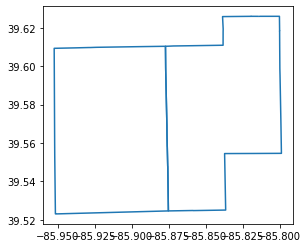

In [273]:
jurisdiction.exterior.to_crs(epsg=4326).plot()


<AxesSubplot:>

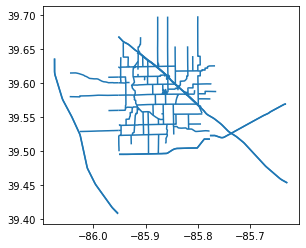

In [274]:
streets = gpd.read_file(
r'/Users/toddtrimble/Downloads/Streets_Roads_INDOT_2015/Roads_2015_INDOT_IN.shp',
bbox = jurisdiction,
)
streets.to_crs(epsg=4326).plot()


<AxesSubplot:>

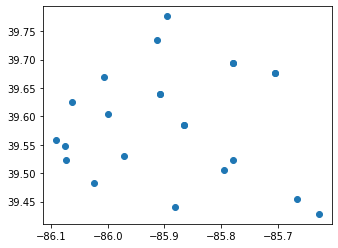

In [275]:
engines = get_engines()
enginelocs = gpd.GeoDataFrame(engines, geometry=gpd.points_from_xy(engines.lon, engines.lat))
enginelocs.plot()

<AxesSubplot:>

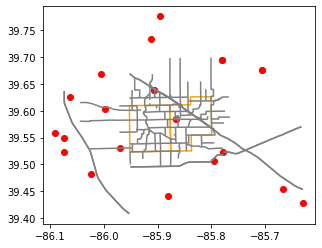

In [276]:
fig, ax = plt.subplots()
jurisdiction.exterior.to_crs(epsg=4326).plot(ax=ax, color='orange')
streets.to_crs(epsg=4326).plot(ax=ax, color='grey')
enginelocs.plot(ax=ax, color='red')

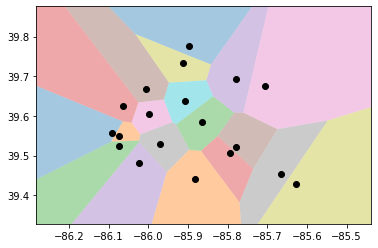

In [277]:
import visualize_voronoi as vv
vv.visualize(engines)

<AxesSubplot:>

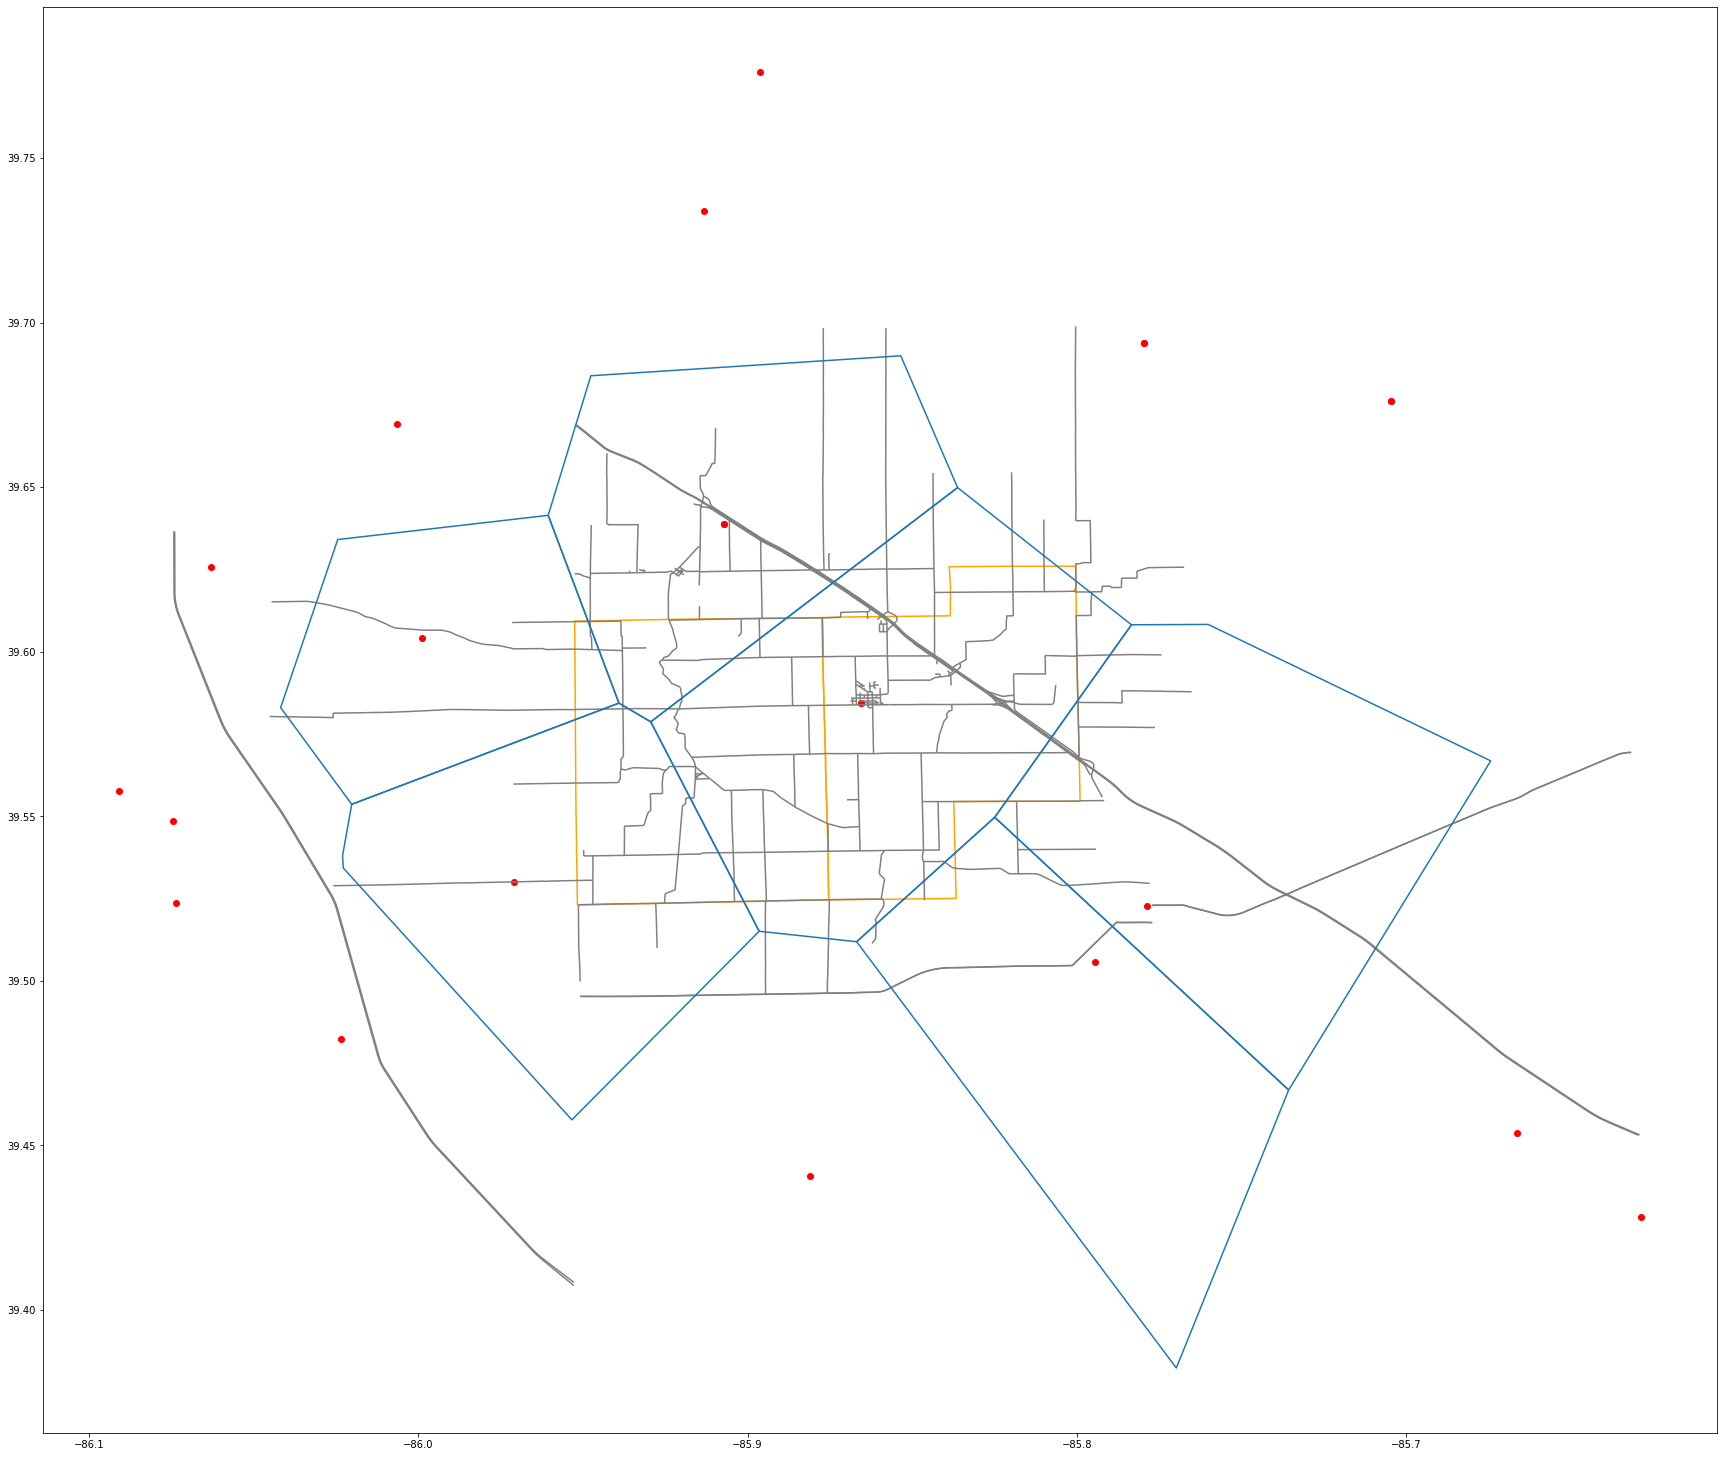

In [327]:
from scipy.spatial.qhull import Voronoi
from shapely.geometry import Polygon

points = list(set(engines[['lon','lat']].itertuples(index=False, name=None)))

vor = Voronoi(points)

regions, vertices = vv.voronoi_finite_polygons_2d(vor)

poly1 = vertices[regions[2]]
data1 = Polygon(poly1)
poly2 = vertices[regions[4]]
data2 = Polygon(poly2)
poly3 = vertices[regions[7]]
data3 = Polygon(poly3)
poly4 = vertices[regions[9]]
data4 = Polygon(poly4)
poly5 = vertices[regions[13]]
data5 = Polygon(poly5)
poly6 = vertices[regions[15]]
data6 = Polygon(poly6)
fig, ax = plt.subplots()
fig.set_size_inches(30, 30)
jurisdiction.exterior.to_crs(epsg=4326).plot(ax=ax, color='orange')
streets.to_crs(epsg=4326).plot(ax=ax, color='grey')
enginelocs.plot(ax=ax, color='red')
gpd.GeoSeries(data1).exterior.plot(ax=ax)
gpd.GeoSeries(data2).exterior.plot(ax=ax)
gpd.GeoSeries(data3).exterior.plot(ax=ax)
gpd.GeoSeries(data4).exterior.plot(ax=ax)
gpd.GeoSeries(data5).exterior.plot(ax=ax)
gpd.GeoSeries(data6).exterior.plot(ax=ax)



<AxesSubplot:>

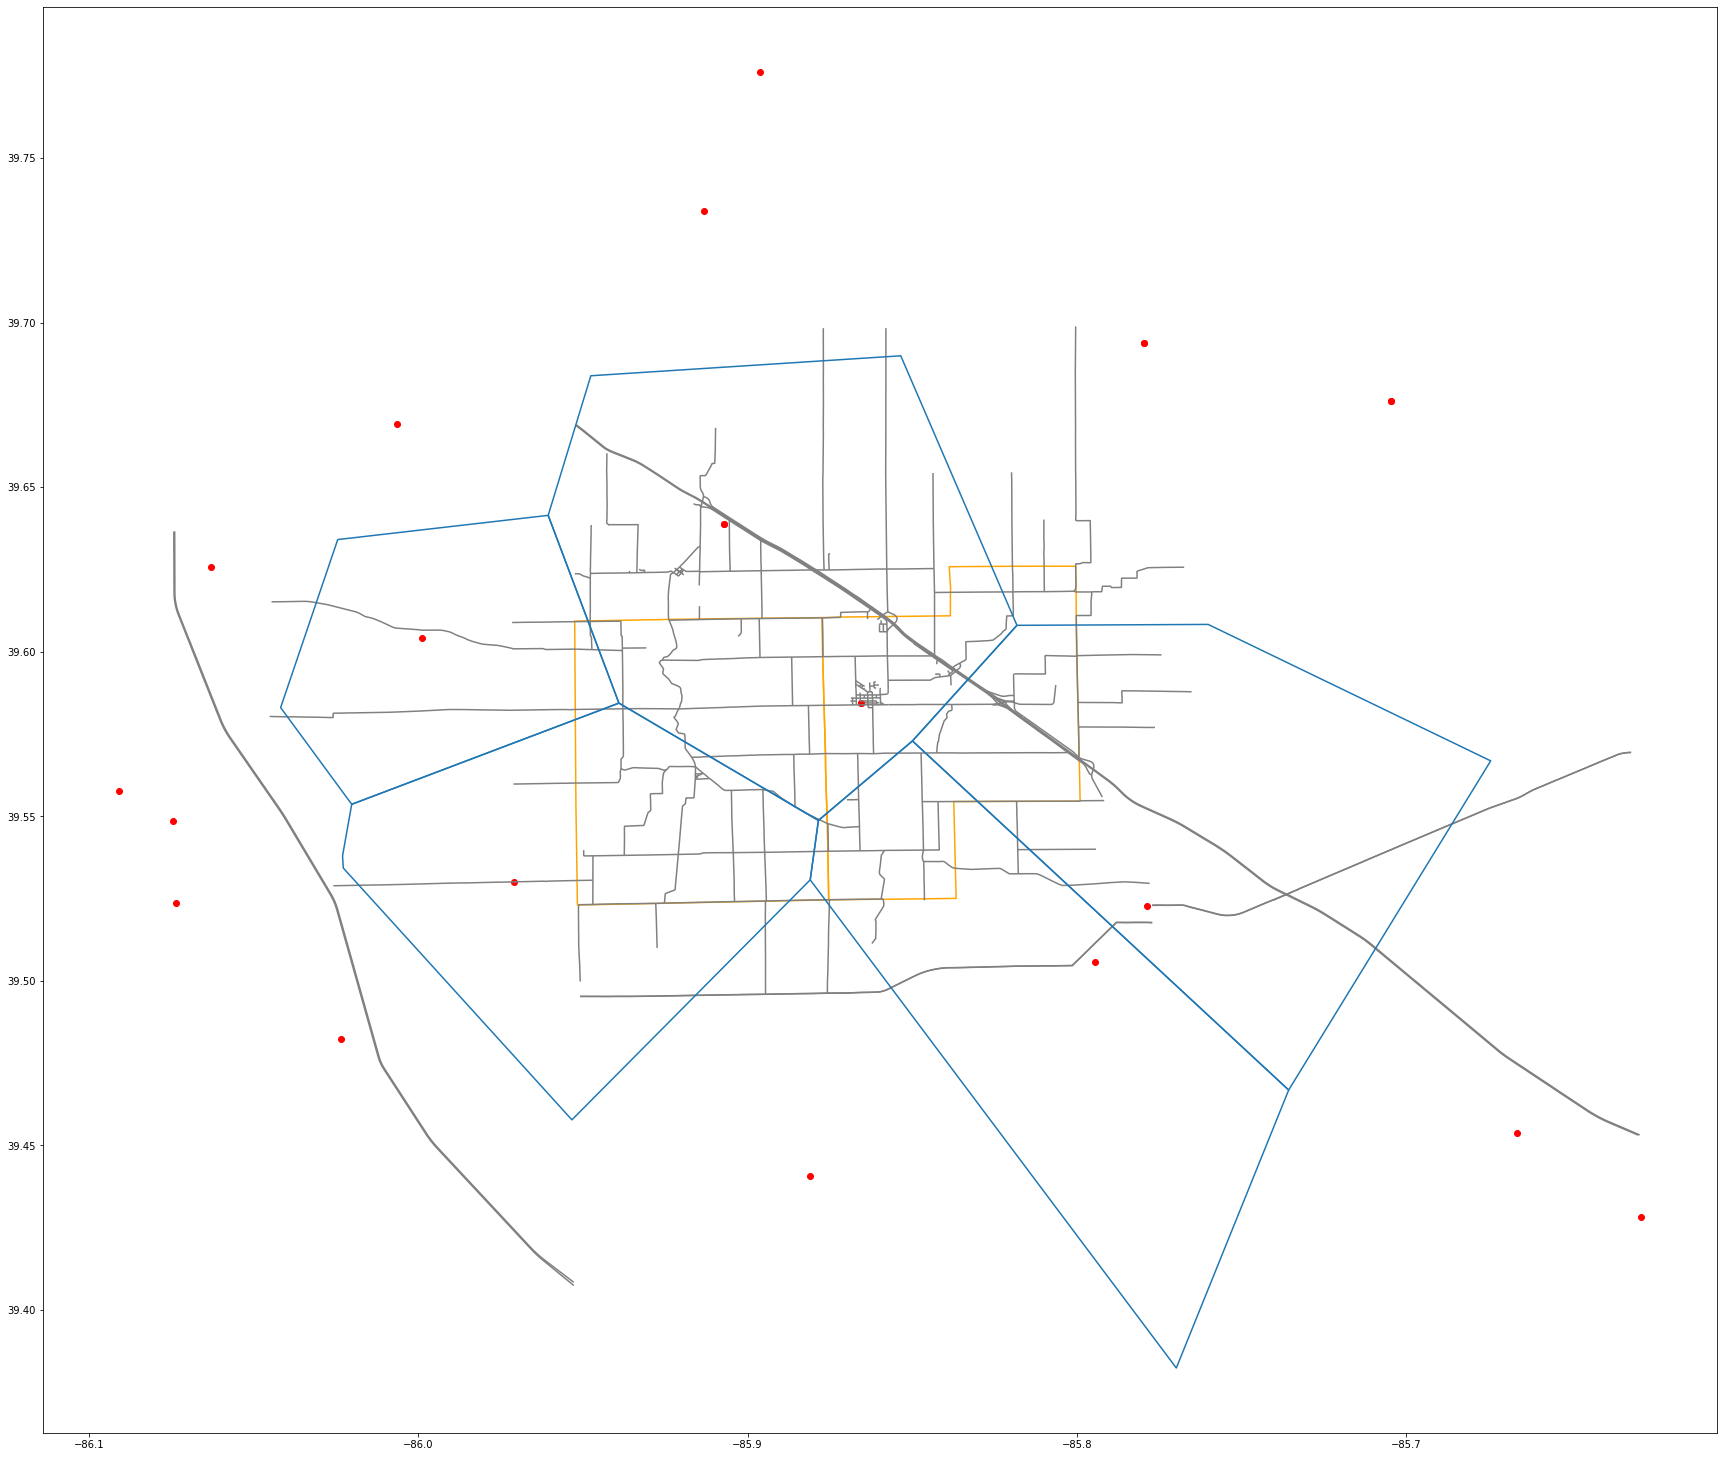

In [358]:
points = []
non_fland_engines = engines[2:]
points = list(set(non_fland_engines[['lon','lat']].itertuples(index=False, name=None)))

vor = Voronoi(points)

regions, vertices = vv.voronoi_finite_polygons_2d(vor)
poly1 = vertices[regions[1]]
data1 = Polygon(poly1)
poly2 = vertices[regions[7]]
data2 = Polygon(poly2)
poly3 = vertices[regions[9]]
data3 = Polygon(poly3)
poly4 = vertices[regions[10]]
data4 = Polygon(poly4)
poly5 = vertices[regions[14]]
data5 = Polygon(poly5)
fig, ax = plt.subplots()
fig.set_size_inches(30, 30)
jurisdiction.exterior.to_crs(epsg=4326).plot(ax=ax, color='orange')
streets.to_crs(epsg=4326).plot(ax=ax, color='grey')
enginelocs.plot(ax=ax, color='red')
gpd.GeoSeries(data1).exterior.plot(ax=ax)
gpd.GeoSeries(data2).exterior.plot(ax=ax)
gpd.GeoSeries(data3).exterior.plot(ax=ax)
gpd.GeoSeries(data4).exterior.plot(ax=ax)
gpd.GeoSeries(data5).exterior.plot(ax=ax)
